In [190]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from config import *
from clustering_utils import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from kneed import KneeLocator
from scipy import stats


from scipy.cluster.hierarchy import dendrogram, linkage

import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from itertools import permutations 
from tqdm import tqdm

In [191]:
all_features_with_info_raw = (pd.read_parquet(FEATURES_DIR / "all_features.pq"))
all_features_with_info_raw = all_features_with_info_raw[~(all_features_with_info_raw.isna().sum(axis=1) == all_features_with_info_raw.shape[1]-2)]


y = pd.DataFrame(all_features_with_info_raw["y"], columns=["y"])


all_features_with_info = (all_features_with_info_raw
        .pipe(remove_low_variance_features)
        .pipe(remove_multicollineraity, y)
        .pipe(remove_outliers, 10.0)
)



X = (all_features_with_info.query("y==1")
 .drop(["participant_id", "y"], axis=1)
 .dropna()
)

X_stdz = pd.DataFrame(StandardScaler().fit_transform(X.values), columns=X.columns)
X_stdz

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
2025-05-09 15:33:23,107 - INFO - clustering_utils.remove_low_variance_features:50 - Kept 473 features out of 520
2025-05-09 15:33:23,199 - INFO - clustering_utils.remove_multicollineraity:108 - Removed 165 highly correlated features: {'SHAPES_duration_mean_fix', 'REACTION_total_acceleration_magnitude_std', 'EVIL_BASTARD_avg_pupil_size_median_fix', 'SHAPES_amplitude_mean_sacc', 'SMOOTH_PURSUITS_avg_pupil_size_min_fix', 'REACTION_peak_velocity_mean_sacc', 'EVIL_BASTARD_fixations_per_second_min', 'KING_DEVICK_avg_pupil_size_mean_fix', 'SHAPES_fixations_per_second_max', 'KING_DEVICK_duration_max_fix', 'FITTS_LAW_fixations_per_second_median', 'FITTS_LAW_avg_pupil_size_min_fix', 'ANTI_SACCADE_avg_pupil_size_min_fix', 'KING_DE

,ANTI_SACCADE_peak_velocity_min_sacc,ANTI_SACCADE_peak_velocity_max_sacc,ANTI_SACCADE_peak_velocity_median_sacc,ANTI_SACCADE_peak_velocity_std_sacc,ANTI_SACCADE_amplitude_mean_sacc,ANTI_SACCADE_amplitude_min_sacc,ANTI_SACCADE_amplitude_max_sacc,ANTI_SACCADE_amplitude_median_sacc,ANTI_SACCADE_amplitude_std_sacc,ANTI_SACCADE_duration_mean_sacc,...,SMOOTH_PURSUITS_y_acceleration_std,SMOOTH_PURSUITS_Var_total,SMOOTH_PURSUITS_distance_to_fixpoint_min,SMOOTH_PURSUITS_distance_to_fixpoint_median,SMOOTH_PURSUITS_distance_to_fixpoint_x_max,SMOOTH_PURSUITS_distance_to_fixpoint_x_median,SMOOTH_PURSUITS_distance_to_fixpoint_y_min,SMOOTH_PURSUITS_distance_to_fixpoint_y_max,SMOOTH_PURSUITS_distance_to_fixpoint_y_median,SMOOTH_PURSUITS_distance_to_fixpoint_y_std
0,0.588982,-1.039149,0.084308,-0.747831,0.430898,1.430449,0.077568,0.719743,-0.133703,-1.142996,...,-0.779059,-0.451600,0.777252,0.831099,0.359675,1.320669,-0.579324,0.581344,-0.041328,0.761614
1,-1.795478,-0.993121,-1.431970,-0.701053,-0.789057,-1.267206,-0.212975,-0.976129,-0.190362,0.985642,...,1.224071,0.101882,-0.196061,0.096283,1.601696,0.444129,-0.579324,0.955130,-0.312898,-0.356629
2,0.032608,-0.017888,0.545784,0.155855,-0.380450,-0.296050,-0.569429,-0.352107,-0.453017,0.585665,...,0.142507,1.437297,-0.305495,2.679262,-0.547216,3.036502,-0.579324,1.028861,2.724007,1.664686
3,-0.285320,-0.748593,-0.838644,-0.632501,-0.411557,-0.511863,-0.026005,-0.770569,0.025420,-0.442455,...,-0.466624,-1.225880,-0.405721,2.677983,0.458173,1.003537,1.034507,1.171616,2.462883,2.782333
4,0.191572,1.800246,-1.835761,0.967658,-1.630150,-1.051394,-1.263505,-1.460664,-1.120691,2.277069,...,0.315900,0.301865,-0.808737,-0.531911,0.939455,-0.809073,-0.579324,-0.899171,-0.204371,-0.734817
5,0.191572,0.371918,-0.443093,-0.041845,-1.031577,0.783012,-1.162622,-0.260339,-1.211502,-1.157125,...,-0.708574,0.558088,0.229732,0.092158,-0.097362,0.673651,-0.579324,-0.594295,-0.307950,0.827416
6,0.509500,2.326699,2.507057,2.150652,-0.608756,-0.511863,-0.831725,-0.506277,-0.627926,1.467791,...,-0.421669,1.005339,1.791789,-0.517528,-0.861182,0.291388,-0.579324,0.691241,-0.641882,-0.026198
7,0.350536,3.089049,1.155592,4.879895,0.332285,-0.403957,0.405774,-0.029083,0.467155,1.903484,...,0.776161,-0.667807,-0.621854,-0.105705,1.463928,-0.106888,-0.579324,1.226861,-0.602941,-0.009594
8,-0.046874,1.708188,0.125511,0.291587,2.125014,0.890918,1.418641,1.564009,1.584596,0.518043,...,0.266274,2.010532,-0.740752,1.041571,1.197436,1.086105,-0.579324,0.501846,1.105432,1.208454
9,0.350536,-0.226455,-1.201232,-0.242059,-0.543672,1.214637,-0.023315,-0.498935,-0.480146,-0.720238,...,-0.471972,-0.952966,-0.166099,-0.260268,-1.436289,-0.734751,-0.579324,-1.766178,0.179219,-1.020888


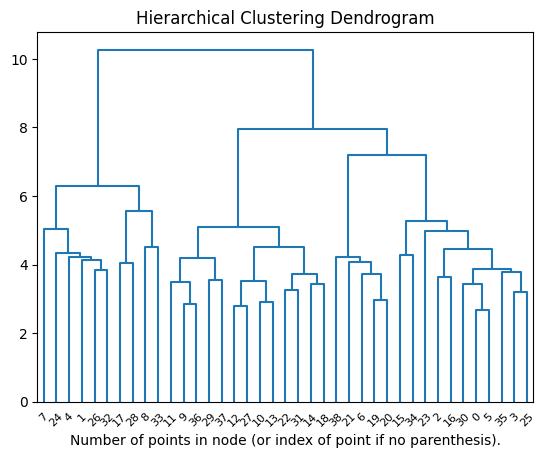

In [197]:



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0,n_clusters=None,  linkage="ward", metric="euclidean")


model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode = 'level', p=100, color_threshold=0)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [206]:
n_clusters_to_try = range(4,5)

clustering_results = {
    "n_clusters": [],
    "silhouette_scores": [],
    "davies_bouldin_score": [],
    "labels": []
}

for n_cluster in n_clusters_to_try:
    model = AgglomerativeClustering(n_clusters=n_cluster, linkage="ward", metric="euclidean")
    model.fit(X)
    labels = model.labels_
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    clustering_results["silhouette_scores"].append(sil_score)
    clustering_results["davies_bouldin_score"].append(db_score)
    clustering_results["n_clusters"].append(n_cluster)
    clustering_results["labels"].append(model.labels_)

clustering_results = pd.DataFrame(clustering_results)

In [207]:
clustering_results

,n_clusters,silhouette_scores,davies_bouldin_score,labels
0,4,0.083266,2.15973,"[1, 0, 1, 1, 0, 1, 3, 0, 0, 2, 2, 2, 2, 2, 2, ..."


In [280]:
feature_importance_results = {
    'best_params': [],
    'n_clusters': [],
    'feature_importances': [],
    'silhouette_scores': [],
    'labels': []
}

for i, row in tqdm(clustering_results.iterrows(), total=clustering_results.shape[0]):
    n_cluster = row["n_clusters"]
    silhoette_scores = row["silhouette_scores"]
    y = row["labels"]
    # Initialize results

    feature_importances = pd.DataFrame(
        np.zeros(X.shape[1]), 
        columns=["Importance"], 
        index=X.columns)

    # Hyperparameters for GridSearch
    parameters = {
        'max_depth': [None, 3, 5, 7, 9, 11],
        'n_estimators': [20, 30, 40, 50, 70, 100],
        'max_features': ['sqrt', 'log2']
    }


    # Find best clf
    grid_search = GridSearchCV(
        RandomForestClassifier(n_jobs=-1, random_state=42), 
        parameters, 
        cv=2,
        verbose=5, 
        n_jobs=-1)

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    best_params = grid_search.best_params_

    # update importances
    feature_importances.loc[X.columns, "Importance"] += importances
    
    feature_importance_results["best_params"].append(best_params)
    feature_importance_results["feature_importances"].append(feature_importances)
    feature_importance_results['n_clusters'].append(n_cluster)
    feature_importance_results["silhouette_scores"].append(silhoette_scores)
    feature_importance_results["labels"].append(y)



  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.700 total time=   0.1s
[CV 2/2] END max_depth=None, max_features=sqrt, n_estimators=30;, score=0.895 total time=   0.1s
[CV 2/2] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.895 total time=   0.1s
[CV 1/2] END max_depth=None, max_features=sqrt, n_estimators=30;, score=0.750 total time=   0.1s
[CV 1/2] END max_depth=None, max_features=sqrt, n_estimators=40;, score=0.700 total time=   0.1s
[CV 2/2] END max_depth=None, max_features=sqrt, n_estimators=40;, score=0.895 total time=   0.1s
[CV 1/2] END max_depth=None, max_features=sqrt, n_estimators=50;, score=0.700 total time=   0.1s
[CV 2/2] END max_depth=None, max_features=sqrt, n_estimators=50;, score=0.842 total time=   0.1s
[CV 1/2] END max_depth=None, max_features=log2, n_estimators=20;, score=0.800 total time=   0.1s
[CV 1/2] END max_depth=None, max_features=sqrt, n_estimators=70;,

100%|██████████| 1/1 [00:03<00:00,  3.29s/it]

[CV 1/2] END max_depth=11, max_features=log2, n_estimators=100;, score=0.750 total time=   0.1s
[CV 2/2] END max_depth=11, max_features=log2, n_estimators=100;, score=0.789 total time=   0.1s
[CV 2/2] END max_depth=11, max_features=sqrt, n_estimators=100;, score=0.789 total time=   0.1s


2025-05-09 16:08:41,580 - INFO - 899067009.<module>:32 - Knee detected at feature rank 4
2025-05-09 16:08:41,580 - INFO - 899067009.<module>:39 - Automatically selected 5 features


<Axes: >

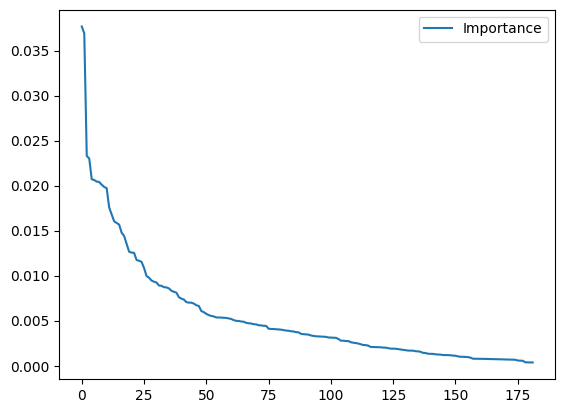

In [276]:
selected_features_results = {
    'best_params': [],
    'selected_features': [],
    "n_clusters": [],
    "silhouette_scores": [],
    "labels": []
    
}

for i, feature_importances in enumerate(feature_importance_results["feature_importances"]):
    
    sorted_feature_importance = (feature_importances
    .sort_values("Importance", ascending=False)
    .reset_index()
    .query("Importance > 0")
    )


    importance_values = sorted_feature_importance["Importance"].values
    feature_ranks = np.arange(len(importance_values))

    # Find knee
    knee = KneeLocator(
        feature_ranks, 
        importance_values, 
        curve='convex', 
        direction='decreasing'
    )
    knee_point = knee.knee

    if knee_point is not None:
        logging.info(f"Knee detected at feature rank {knee_point}")
    else:
        logging.warning("Knee point is not detected")
        knee_point = len(sorted_feature_importance) - 1

    # Select features above knee
    selected_features = sorted_feature_importance.iloc[:knee_point+1]
    logging.info(f"Automatically selected {selected_features.shape[0]} features")

    selected_features_results["selected_features"].append(selected_features)
    selected_features_results["n_clusters"].append(feature_importance_results["n_clusters"][i])
    selected_features_results["silhouette_scores"].append(feature_importance_results["silhouette_scores"][i])
    selected_features_results["labels"].append(feature_importance_results["labels"][i])
    selected_features_results["best_params"].append(feature_importance_results["best_params"][i])

sorted_feature_importance.plot()

In [277]:
selected_features_results["selected_features"]

[                                     index  Importance
 0        SHAPES_distance_to_fixpoint_x_max    0.037668
 1       SMOOTH_PURSUITS_x_acceleration_std    0.036917
 2            EVIL_BASTARD_duration_max_fix    0.023291
 3  EVIL_BASTARD_distance_to_fixpoint_x_max    0.023005
 4             REACTION_duration_median_fix    0.020706]

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: F

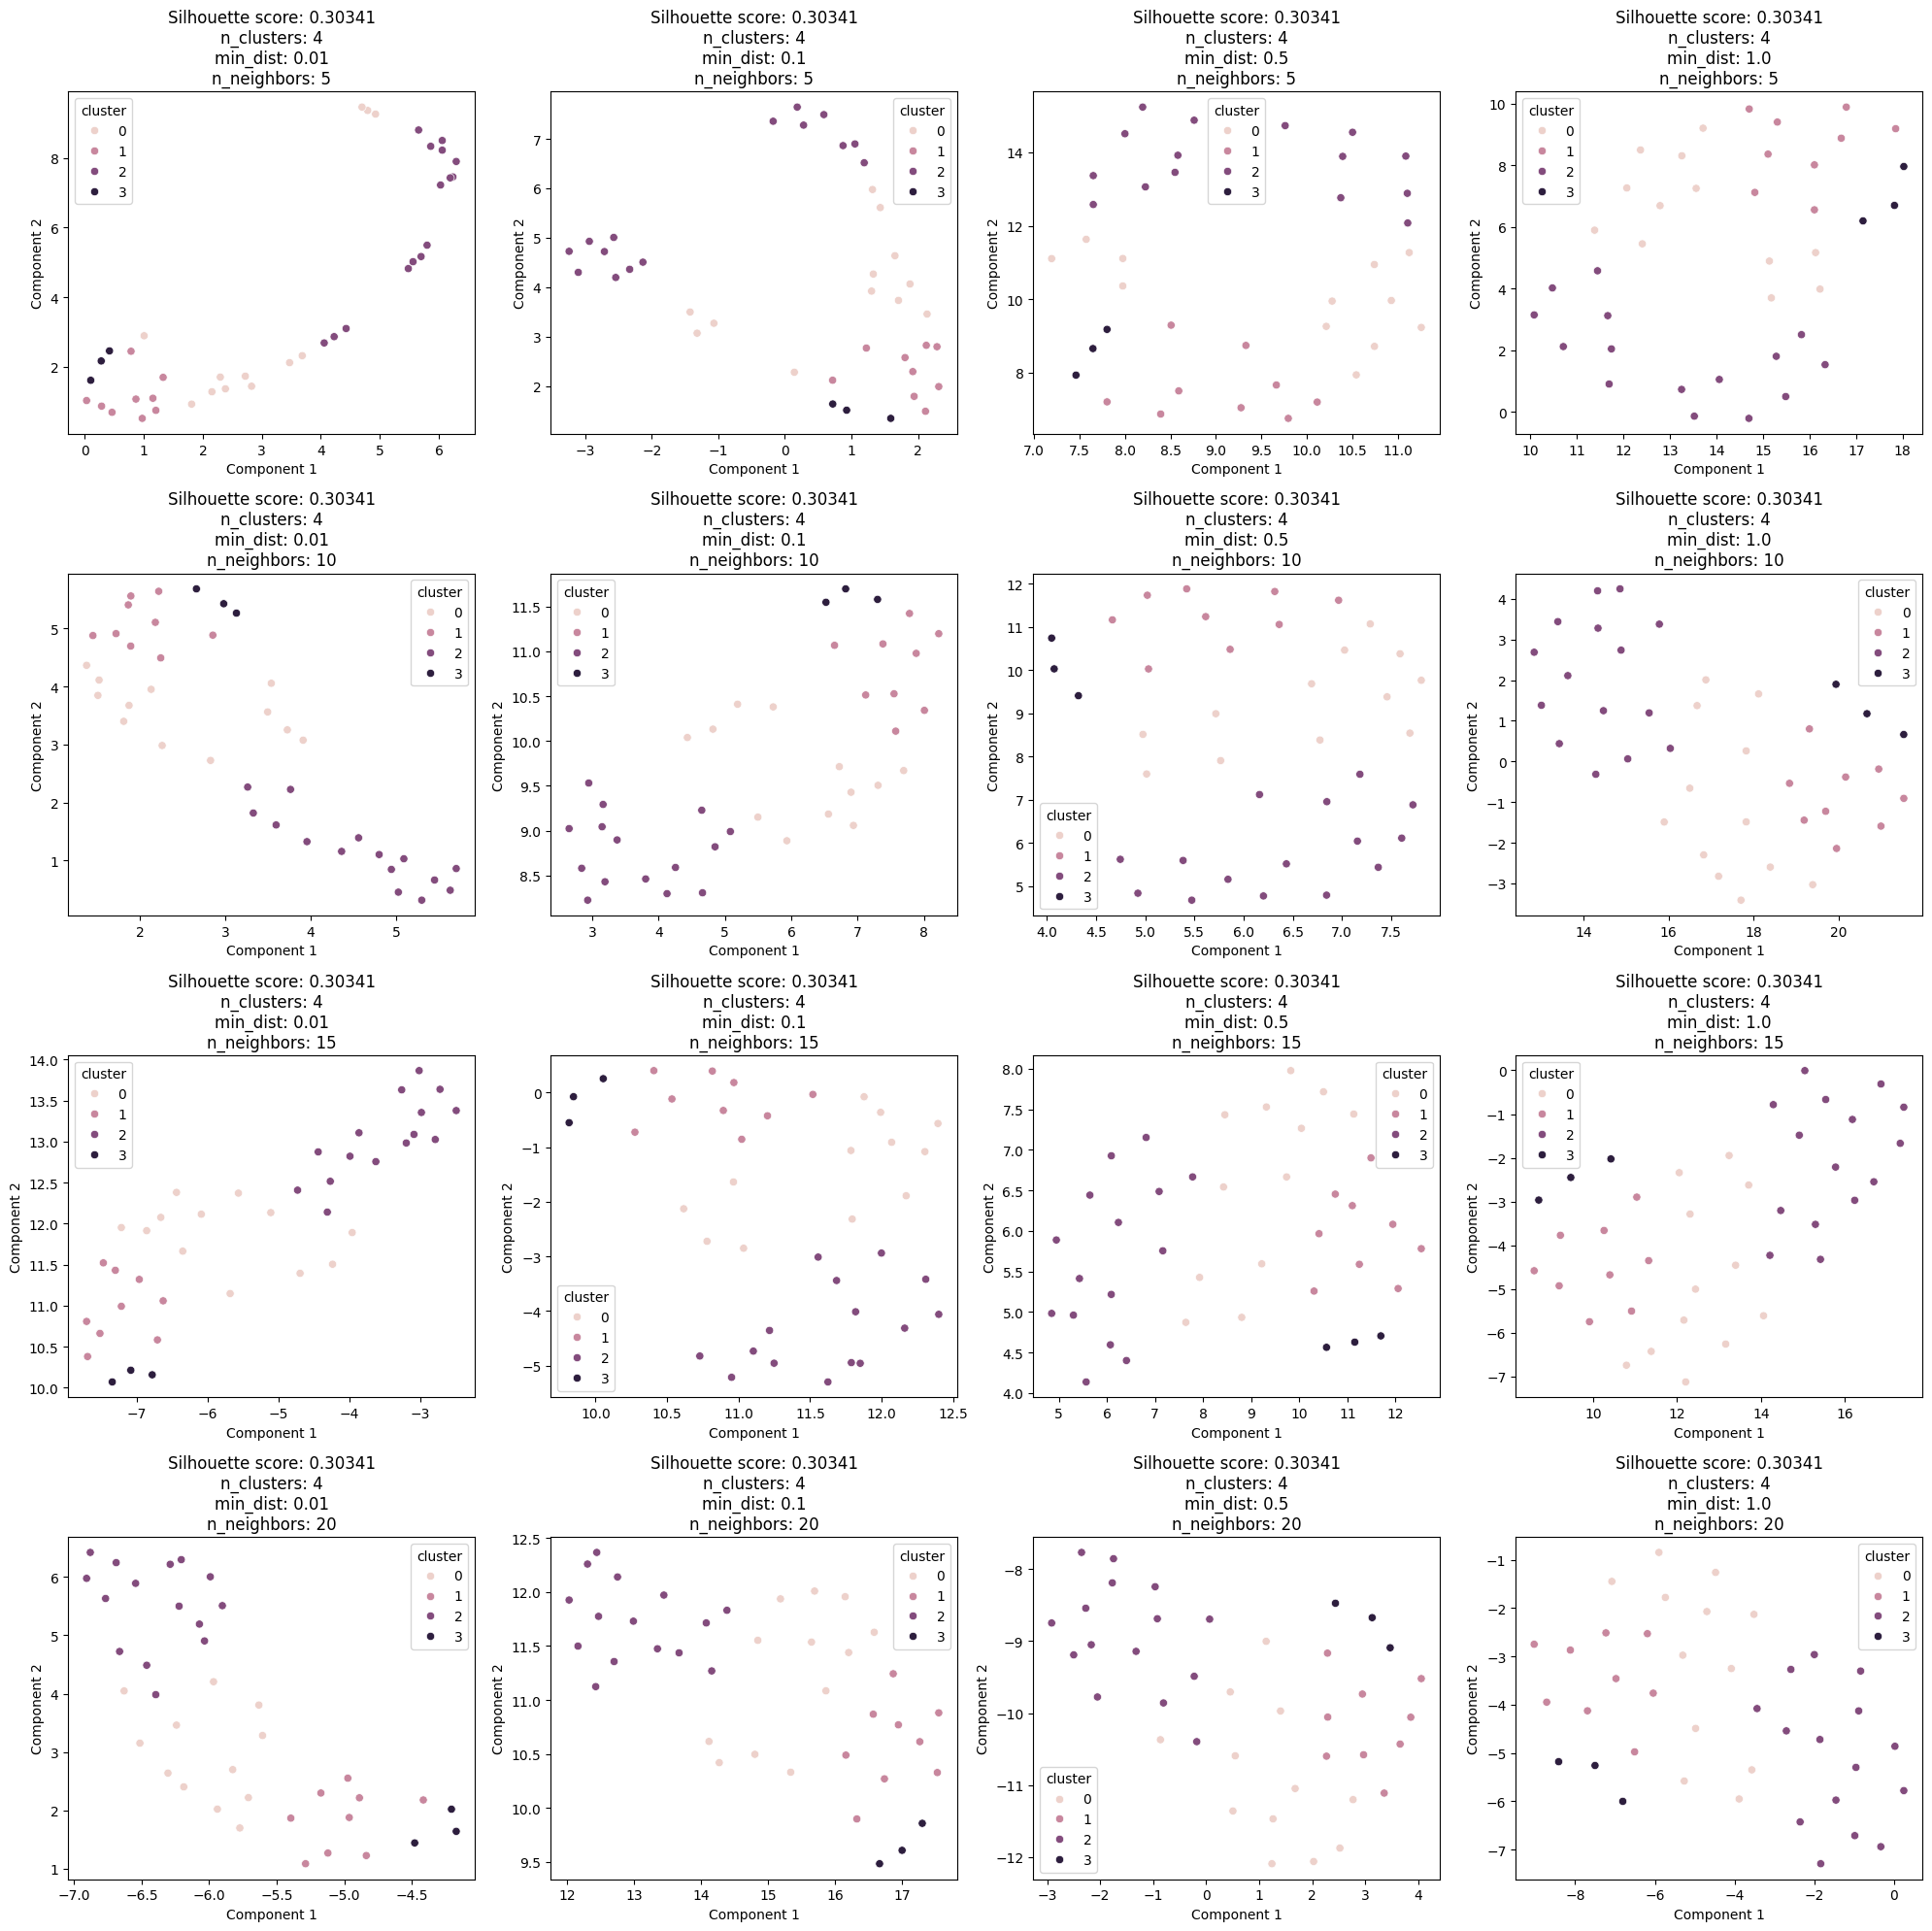

In [278]:
      
def plot_scatter_of_clusters(X, clustering_model = None, reducer=None, labels=None , arrows:bool=True, ax=None, title_print: dict = None):
    coeff = None
    n_features_provided = X.shape[1]
    if reducer is not None and n_features_provided > 2:
        X_reduced = reducer.fit_transform(X)
        if "PCA" in reducer.__str__():
            coeff = reducer.components_
        X_reduced_df = pd.DataFrame({"Component 1": X_reduced[:,0]
                                ,'Component 2': X_reduced[:,1]})
    else:
        if n_features_provided != 2:
            raise ValueError('Dimensionality reduction method must be provided when number of features are not 2')
        X_reduced_df = X

    x_var_name, y_var_name = X_reduced_df.columns

    if clustering_model is not None:
        try: 
            clustering_labels = clustering_model.labels_
        except:
            clustering_labels = clustering_model.predict(X)
            
        X_reduced_df["cluster"] = clustering_labels

        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name, hue='cluster', ax=ax)
        ax.set_title(f"Silhouette score: {round(silhouette_score(X, clustering_labels),5)}\nn_clusters: {len(np.unique(clustering_labels))}\nmin_dist: {title_print["min_dist"]}\nn_neighbors: {title_print["n_neighbors"]}")
        
    else:
        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name,ax=ax)
    
    if coeff is not None and arrows:
        n = coeff.shape[1]
        for i in range(n):
            plt.arrow(0, 0, coeff[0,i]*5, coeff[1,i]*5,color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                print(labels[i])
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, labels[i], color = 'g', ha = 'center', va = 'center')
  
selected_features_to_plot = list(selected_features_results["selected_features"][0].sort_values("Importance", ascending=False)["index"].unique())


model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
model.fit(X[selected_features_to_plot])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

axs = np.array(ax).reshape(-1)


n_neighbors = np.repeat([5, 10, 15, 20],4)
min_dist = np.tile(np.array([0.01, 0.1, 0.5, 1]), 4)

for i in range(16):
    plot_scatter_of_clusters(X[selected_features_to_plot],
                            clustering_model=model,
                            reducer=umap.UMAP(n_neighbors=n_neighbors[i],
                                            min_dist=min_dist[i]),
                            ax=axs[i],
                            title_print={'n_neighbors': n_neighbors[i],
                                         'min_dist': min_dist[i]})
plt.tight_layout()


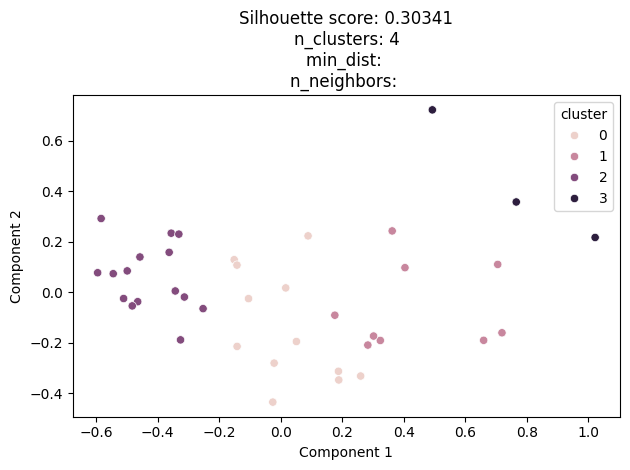

In [279]:
fig, ax = plt.subplots()
plot_scatter_of_clusters(X[selected_features_to_plot],
                            clustering_model=model,
                            reducer=PCA(),
                            ax=ax,
                            arrows=False,
                            title_print={'n_neighbors': '',
                                         'min_dist': ''})
plt.tight_layout()

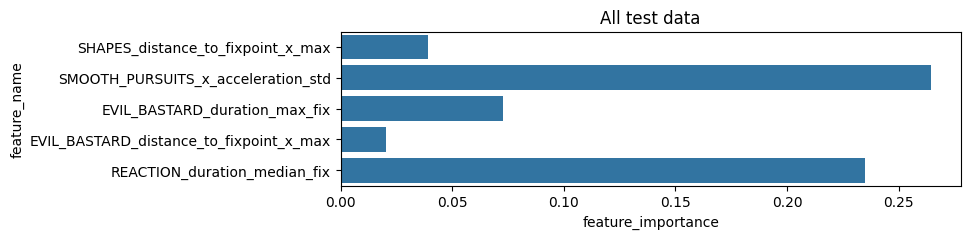

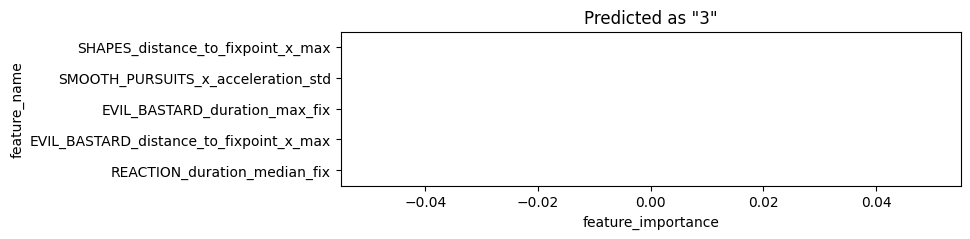

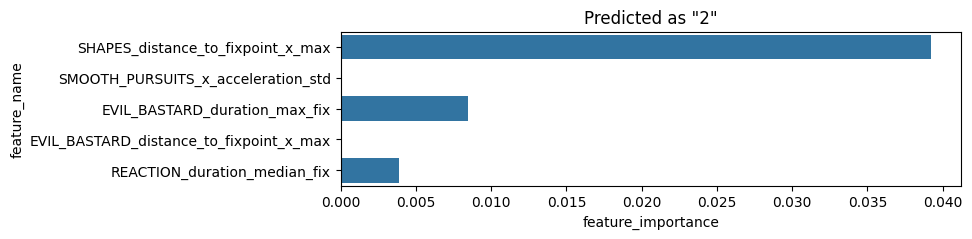

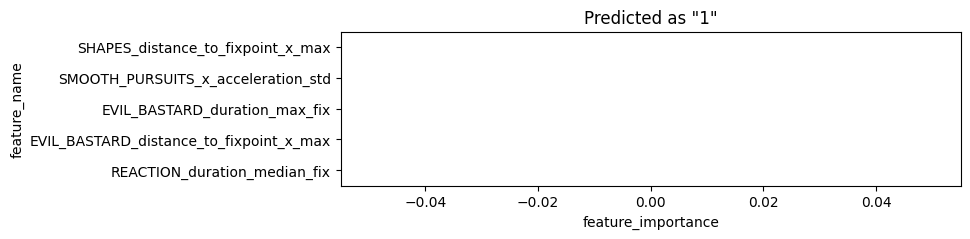

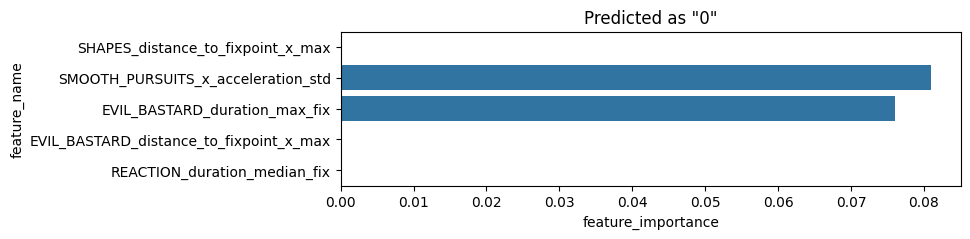

In [285]:

from sklearn.inspection import permutation_importance

def plot_feature_importances(model, x, y, title):
    result = permutation_importance(model, x, y, n_repeats=100, random_state=0)
    df = pd.DataFrame({'feature_name': x.columns, 'feature_importance': result.importances_mean})
    plt.figure(figsize=(8, 2))
    sns.barplot(data=df, x='feature_importance', y='feature_name')
    plt.title(title)
    plt.show()

model = RandomForestClassifier()
model.fit(X[selected_features_to_plot],y)

plot_feature_importances(model, X[selected_features_to_plot], y, 'All test data')

y_pred = model.predict(X[selected_features_to_plot])
plot_feature_importances(model, X[selected_features_to_plot][y_pred == 3], y[y_pred == 3], 'Predicted as "3"')
plot_feature_importances(model, X[selected_features_to_plot][y_pred == 2], y[y_pred == 2], 'Predicted as "2"')
plot_feature_importances(model, X[selected_features_to_plot][y_pred == 1], y[y_pred == 1], 'Predicted as "1"')
plot_feature_importances(model, X[selected_features_to_plot][y_pred == 0], y[y_pred == 0], 'Predicted as "0"')